In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Enhanced plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

In [6]:
print("\n1. LOADING CLEANED DATA")
print("-" * 80)

# CORRECTED PATH: Using ../data/cleaned/ instead of ../data/processed/
df = pd.read_csv('../data/cleaned/fraudTrain_cleaned.csv')

# Convert date columns back to datetime (they were saved as strings)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

print(f"✓ Loaded cleaned dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"✓ Date range: {df['trans_date_trans_time'].min()} to {df['trans_date_trans_time'].max()}")
print(f"✓ Fraud rate: {df['is_fraud'].mean() * 100:.4f}%")

# Quick check of columns
print(f"\n📋 Available columns ({len(df.columns)}):")
print(df.columns.tolist())


1. LOADING CLEANED DATA
--------------------------------------------------------------------------------


✓ Loaded cleaned dataset: 1,296,675 rows × 39 columns
✓ Date range: 2019-01-01 00:00:18 to 2020-06-21 12:13:37
✓ Fraud rate: 0.5789%

📋 Available columns (39):
['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'transaction_hour', 'transaction_day', 'transaction_day_of_week', 'transaction_month', 'transaction_year', 'transaction_date', 'is_weekend', 'is_night', 'amount_rounded', 'is_round_amount', 'amount_category', 'amt_log', 'distance_km', 'is_local', 'is_regional', 'is_long_distance', 'distance_log']


# 2. FRAUD VS NON-FRAUD: TRANSACTION AMOUNTS


2. ANALYZING FRAUD vs NON-FRAUD TRANSACTION AMOUNTS
--------------------------------------------------------------------------------



📊 Statistical Comparison:

FRAUDULENT Transactions:
  Count: 7,506
  Mean: $531.32
  Median: $396.50
  Std Dev: $390.56
  Min: $1.06
  Max: $1376.04

LEGITIMATE Transactions:
  Count: 1,289,169
  Mean: $67.67
  Median: $47.28
  Std Dev: $154.01
  Min: $1.00
  Max: $28948.90

📈 T-test: t-statistic=256.0782, p-value=0.0000e+00
   → Fraudulent transactions have SIGNIFICANTLY different amounts


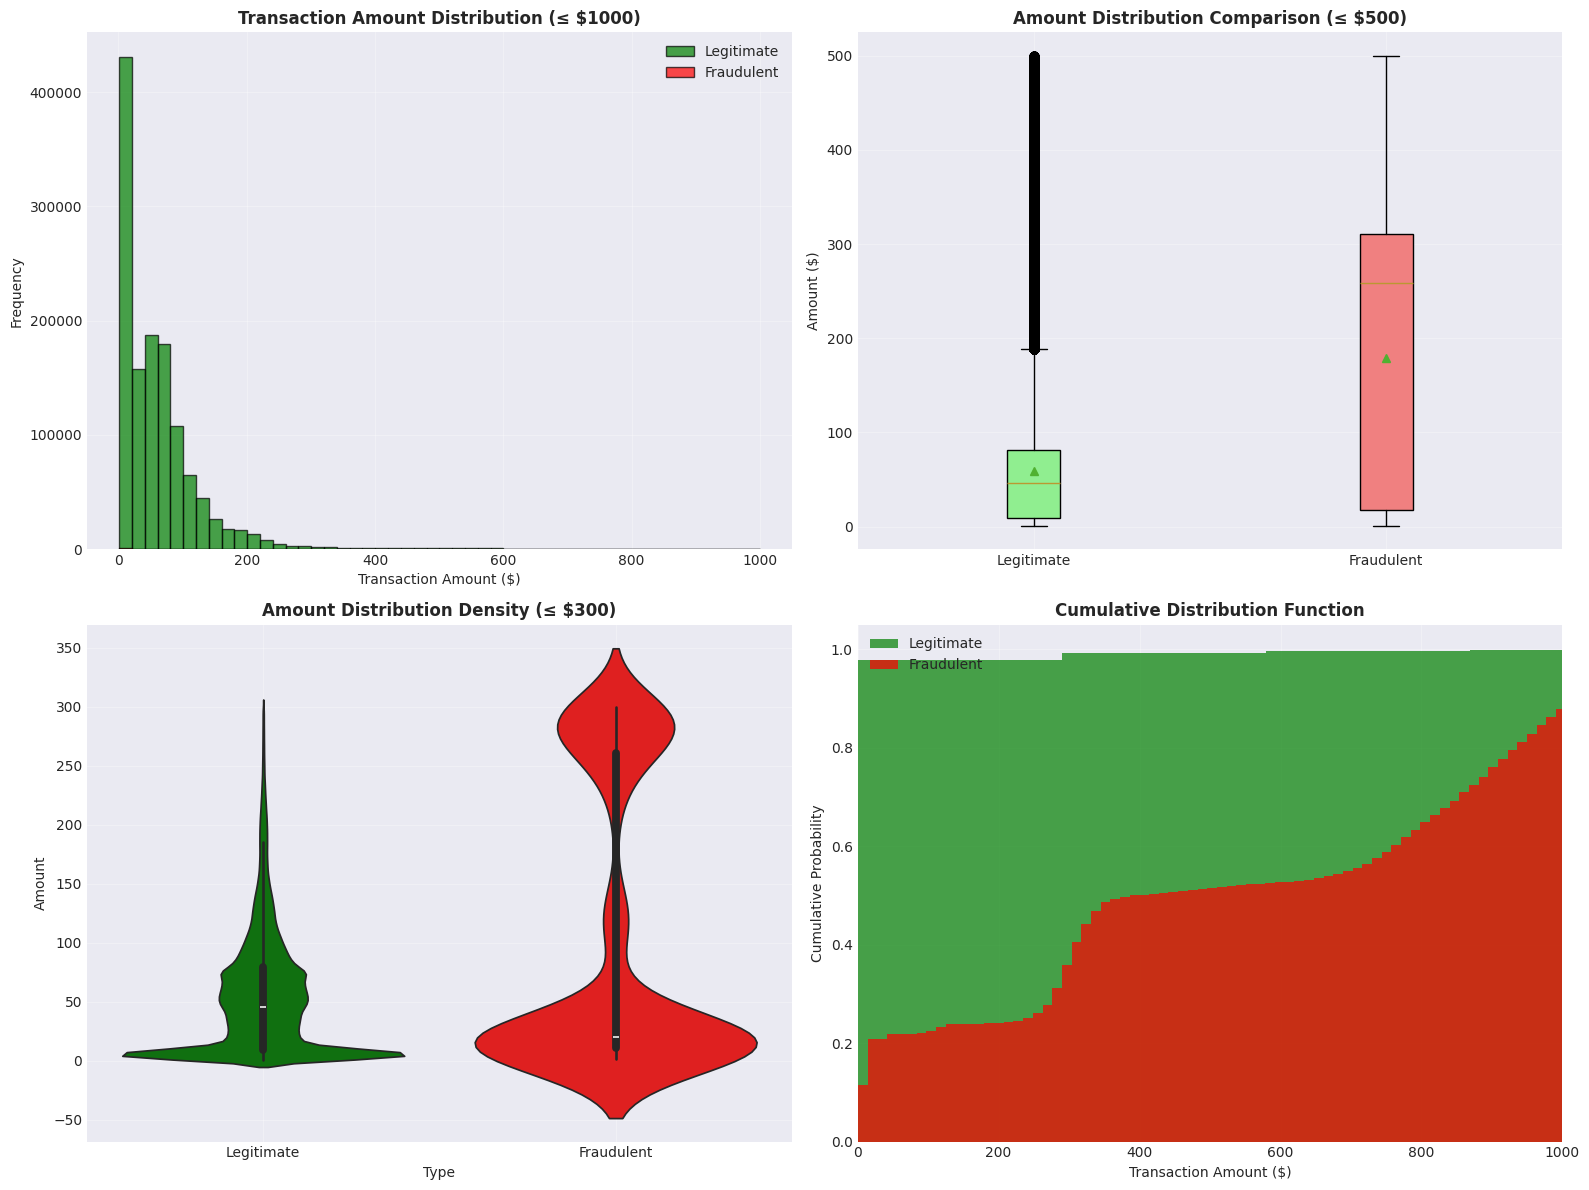


✓ Saved: reports/day3_fraud_vs_legit_amounts.png


In [7]:
print("\n2. ANALYZING FRAUD vs NON-FRAUD TRANSACTION AMOUNTS")
print("-" * 80)

fraud_amounts = df[df['is_fraud'] == 1]['amt']
legit_amounts = df[df['is_fraud'] == 0]['amt']

print("\n📊 Statistical Comparison:")
print(f"\nFRAUDULENT Transactions:")
print(f"  Count: {len(fraud_amounts):,}")
print(f"  Mean: ${fraud_amounts.mean():.2f}")
print(f"  Median: ${fraud_amounts.median():.2f}")
print(f"  Std Dev: ${fraud_amounts.std():.2f}")
print(f"  Min: ${fraud_amounts.min():.2f}")
print(f"  Max: ${fraud_amounts.max():.2f}")

print(f"\nLEGITIMATE Transactions:")
print(f"  Count: {len(legit_amounts):,}")
print(f"  Mean: ${legit_amounts.mean():.2f}")
print(f"  Median: ${legit_amounts.median():.2f}")
print(f"  Std Dev: ${legit_amounts.std():.2f}")
print(f"  Min: ${legit_amounts.min():.2f}")
print(f"  Max: ${legit_amounts.max():.2f}")

# Statistical test
t_stat, p_value = stats.ttest_ind(fraud_amounts, legit_amounts)
print(f"\n📈 T-test: t-statistic={t_stat:.4f}, p-value={p_value:.4e}")
print(f"   → Fraudulent transactions have {'SIGNIFICANTLY' if p_value < 0.05 else 'NOT significantly'} different amounts")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution comparison (limited to $1000 for visibility)
axes[0, 0].hist(legit_amounts[legit_amounts <= 1000], bins=50, alpha=0.7, 
                label='Legitimate', color='green', edgecolor='black')
axes[0, 0].hist(fraud_amounts[fraud_amounts <= 1000], bins=50, alpha=0.7, 
                label='Fraudulent', color='red', edgecolor='black')
axes[0, 0].set_xlabel('Transaction Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Amount Distribution (≤ $1000)', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot comparison
box_data = [legit_amounts[legit_amounts <= 500], fraud_amounts[fraud_amounts <= 500]]
bp = axes[0, 1].boxplot(box_data, labels=['Legitimate', 'Fraudulent'], 
                         patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[0, 1].set_ylabel('Amount ($)')
axes[0, 1].set_title('Amount Distribution Comparison (≤ $500)', fontweight='bold', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# 3. Violin plot
violin_data = pd.DataFrame({
    'Amount': list(legit_amounts[legit_amounts <= 300]) + list(fraud_amounts[fraud_amounts <= 300]),
    'Type': ['Legitimate'] * len(legit_amounts[legit_amounts <= 300]) + 
            ['Fraudulent'] * len(fraud_amounts[fraud_amounts <= 300])
})
sns.violinplot(data=violin_data, x='Type', y='Amount', ax=axes[1, 0], palette=['green', 'red'])
axes[1, 0].set_title('Amount Distribution Density (≤ $300)', fontweight='bold', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# 4. Cumulative distribution
axes[1, 1].hist(legit_amounts, bins=100, cumulative=True, density=True, 
                alpha=0.7, label='Legitimate', color='green')
axes[1, 1].hist(fraud_amounts, bins=100, cumulative=True, density=True, 
                alpha=0.7, label='Fraudulent', color='red')
axes[1, 1].set_xlabel('Transaction Amount ($)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Distribution Function', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim(0, 1000)

plt.tight_layout()
plt.savefig('../reports/day3_fraud_vs_legit_amounts.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: reports/day3_fraud_vs_legit_amounts.png")

# 3. FRAUD BY TRANSACTION CATEGORY


3. ANALYZING FRAUD BY TRANSACTION CATEGORY
--------------------------------------------------------------------------------

📊 Fraud Analysis by Category:
                Fraud_Count  Fraud_Rate  Total_Trans  Avg_Amount  \
category                                                           
shopping_net           1713        2.00        97543       88.42   
grocery_pos            1743        1.00       123638      116.96   
misc_net                915        1.00        63287       80.87   
shopping_pos            843        1.00       116672       79.78   
food_dining             151        0.00        91461       51.09   
entertainment           233        0.00        94014       64.21   
health_fitness          133        0.00        85879       54.18   
grocery_net             134        0.00        45452       53.67   
gas_transport           618        0.00       131659       63.43   
home                    198        0.00       123115       58.27   
misc_pos                250 

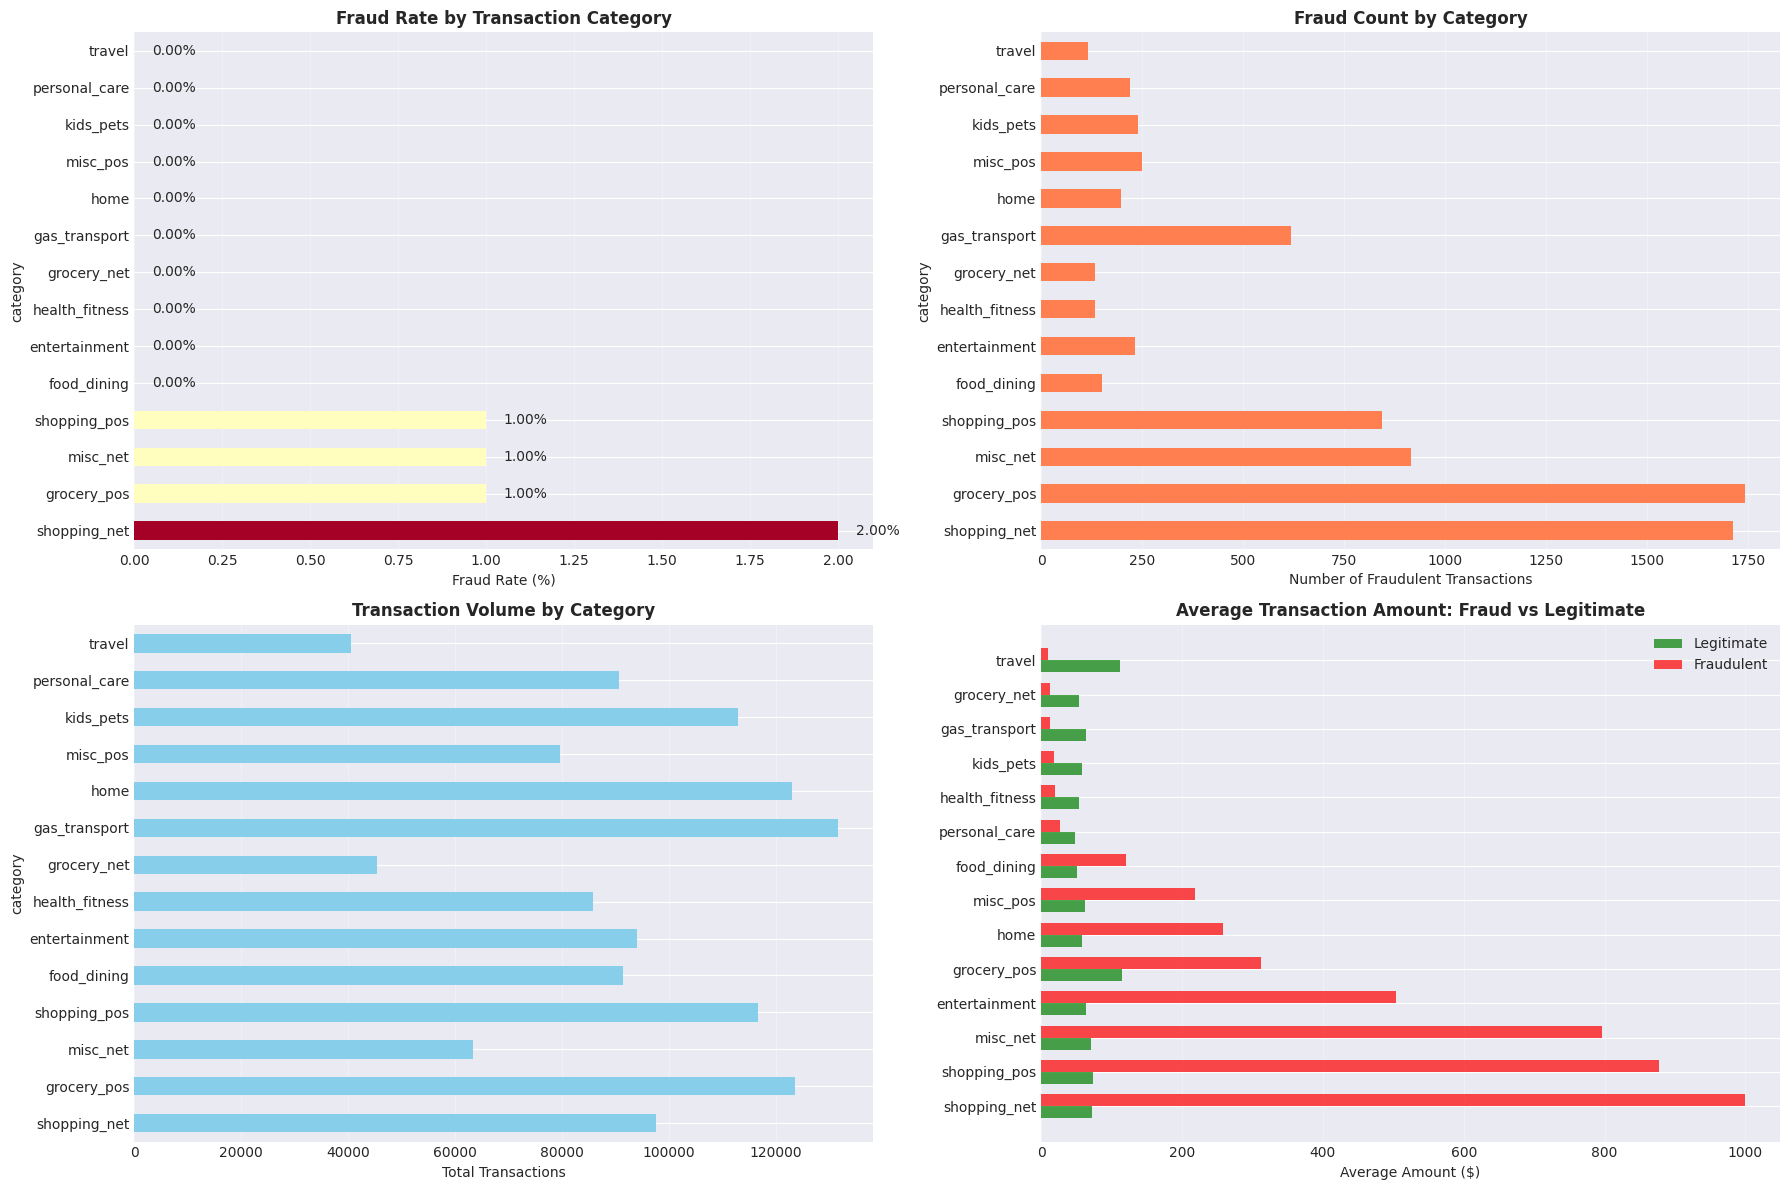


✓ Saved: reports/day3_fraud_by_category.png


In [8]:
print("\n3. ANALYZING FRAUD BY TRANSACTION CATEGORY")
print("-" * 80)

# Calculate fraud metrics by category
category_analysis = df.groupby('category').agg({
    'is_fraud': ['sum', 'mean', 'count'],
    'amt': ['mean', 'median', 'sum']
}).round(2)

category_analysis.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans', 
                              'Avg_Amount', 'Median_Amount', 'Total_Amount']
category_analysis['Fraud_Rate'] = category_analysis['Fraud_Rate'] * 100
category_analysis = category_analysis.sort_values('Fraud_Rate', ascending=False)

print("\n📊 Fraud Analysis by Category:")
print(category_analysis)

# Save to CSV
category_analysis.to_csv('../reports/day3_fraud_by_category.csv')
print("\n✓ Saved: reports/day3_fraud_by_category.csv")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Fraud rate by category
category_analysis['Fraud_Rate'].plot(kind='barh', ax=axes[0, 0], 
                                      color=plt.cm.RdYlGn_r(category_analysis['Fraud_Rate']/category_analysis['Fraud_Rate'].max()))
axes[0, 0].set_xlabel('Fraud Rate (%)')
axes[0, 0].set_title('Fraud Rate by Transaction Category', fontweight='bold', fontsize=12)
axes[0, 0].grid(alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(category_analysis['Fraud_Rate']):
    axes[0, 0].text(v + 0.05, i, f'{v:.2f}%', va='center')

# 2. Fraud count by category
category_analysis['Fraud_Count'].plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_xlabel('Number of Fraudulent Transactions')
axes[0, 1].set_title('Fraud Count by Category', fontweight='bold', fontsize=12)
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. Total transactions by category
category_analysis['Total_Trans'].plot(kind='barh', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_xlabel('Total Transactions')
axes[1, 0].set_title('Transaction Volume by Category', fontweight='bold', fontsize=12)
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. Average amount by category (fraud vs legit)
fraud_avg = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=False)
legit_avg = df[df['is_fraud'] == 0].groupby('category')['amt'].mean().sort_values(ascending=False)

x = np.arange(len(fraud_avg))
width = 0.35
axes[1, 1].barh(x - width/2, legit_avg[fraud_avg.index], width, label='Legitimate', color='green', alpha=0.7)
axes[1, 1].barh(x + width/2, fraud_avg, width, label='Fraudulent', color='red', alpha=0.7)
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(fraud_avg.index)
axes[1, 1].set_xlabel('Average Amount ($)')
axes[1, 1].set_title('Average Transaction Amount: Fraud vs Legitimate', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/day3_fraud_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: reports/day3_fraud_by_category.png")

# 4. FRAUD BY TIME PATTERNS


4. ANALYZING FRAUD BY TIME PATTERNS
--------------------------------------------------------------------------------

⏰ Fraud by Hour of Day:
                  Fraud_Count  Fraud_Rate  Total_Trans
transaction_hour                                      
0                         635        1.49        42502
1                         658        1.53        42869
2                         625        1.47        42656
3                         609        1.42        42769
4                          46        0.11        41863
5                          60        0.14        42171
6                          40        0.09        42300
7                          56        0.13        42203
8                          49        0.12        42505
9                          47        0.11        42185
10                         40        0.09        42271
11                         42        0.10        42082
12                         67        0.10        65257
13                         80   

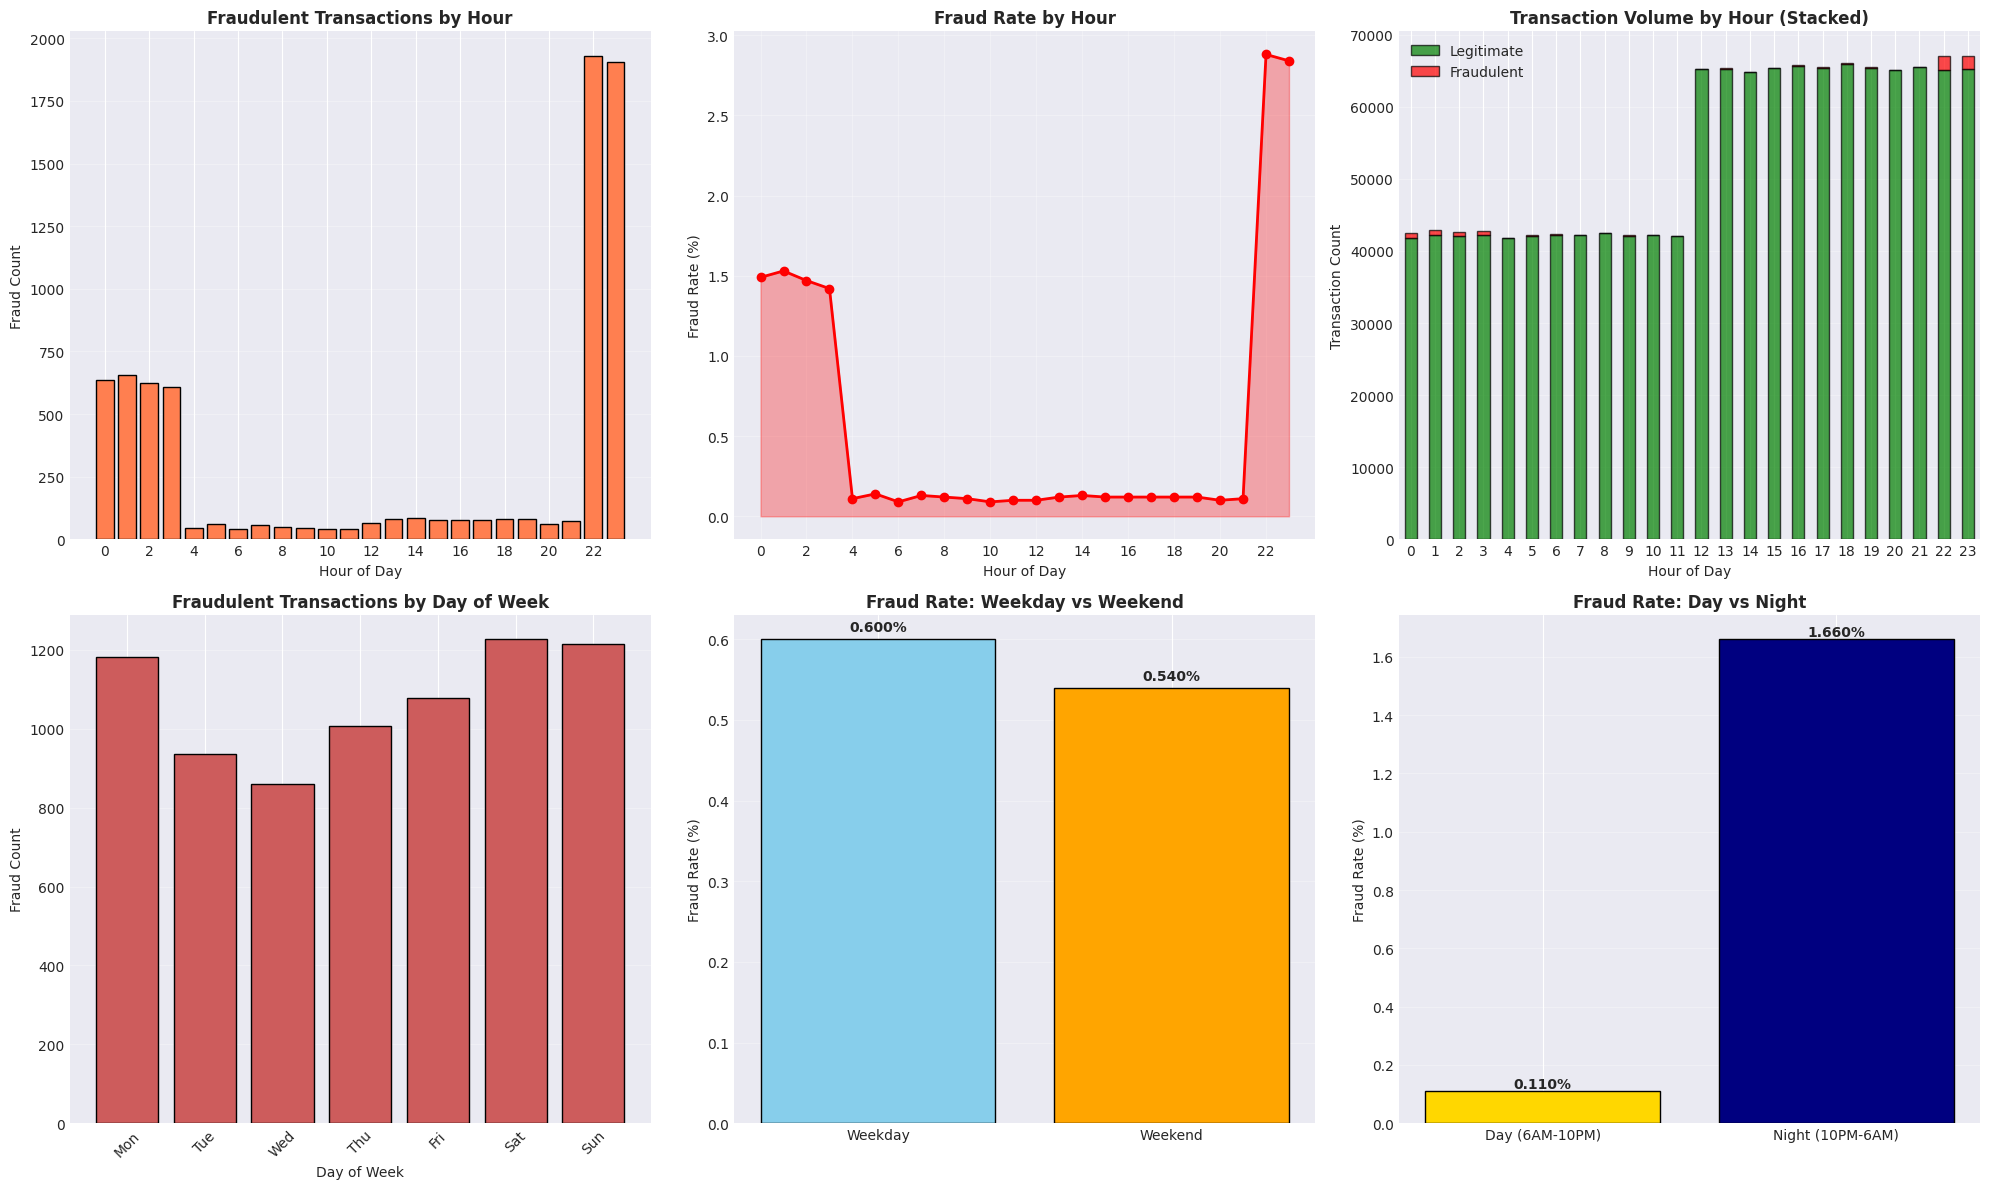


✓ Saved: reports/day3_fraud_by_time.png


In [9]:
print("\n4. ANALYZING FRAUD BY TIME PATTERNS")
print("-" * 80)

# Fraud by hour
fraud_by_hour = df.groupby('transaction_hour').agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
fraud_by_hour.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans']
fraud_by_hour['Fraud_Rate'] = fraud_by_hour['Fraud_Rate'] * 100

print("\n⏰ Fraud by Hour of Day:")
print(fraud_by_hour)

# Fraud by day of week
fraud_by_dow = df.groupby('transaction_day').agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
fraud_by_dow.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans']
fraud_by_dow['Fraud_Rate'] = fraud_by_dow['Fraud_Rate'] * 100

# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraud_by_dow = fraud_by_dow.reindex(day_order)

print("\n📅 Fraud by Day of Week:")
print(fraud_by_dow)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Fraud count by hour
axes[0, 0].bar(fraud_by_hour.index, fraud_by_hour['Fraud_Count'], color='coral', edgecolor='black')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Fraud Count')
axes[0, 0].set_title('Fraudulent Transactions by Hour', fontweight='bold', fontsize=12)
axes[0, 0].grid(alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. Fraud rate by hour
axes[0, 1].plot(fraud_by_hour.index, fraud_by_hour['Fraud_Rate'], 
                marker='o', linewidth=2, markersize=6, color='red')
axes[0, 1].fill_between(fraud_by_hour.index, fraud_by_hour['Fraud_Rate'], alpha=0.3, color='red')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by Hour', fontweight='bold', fontsize=12)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 2))

# 3. Transaction volume by hour (stacked)
hour_data = df.groupby(['transaction_hour', 'is_fraud']).size().unstack(fill_value=0)
hour_data.plot(kind='bar', stacked=True, ax=axes[0, 2], 
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Transaction Count')
axes[0, 2].set_title('Transaction Volume by Hour (Stacked)', fontweight='bold', fontsize=12)
axes[0, 2].legend(['Legitimate', 'Fraudulent'])
axes[0, 2].grid(alpha=0.3, axis='y')
axes[0, 2].tick_params(axis='x', rotation=0)

# 4. Fraud by day of week
axes[1, 0].bar(range(7), fraud_by_dow['Fraud_Count'], color='indianred', edgecolor='black')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Fraud Count')
axes[1, 0].set_title('Fraudulent Transactions by Day of Week', fontweight='bold', fontsize=12)
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
axes[1, 0].grid(alpha=0.3, axis='y')

# 5. Weekend vs Weekday
weekend_analysis = df.groupby('is_weekend').agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
weekend_analysis.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans']
weekend_analysis['Fraud_Rate'] = weekend_analysis['Fraud_Rate'] * 100

axes[1, 1].bar(['Weekday', 'Weekend'], weekend_analysis['Fraud_Rate'], 
               color=['skyblue', 'orange'], edgecolor='black')
axes[1, 1].set_ylabel('Fraud Rate (%)')
axes[1, 1].set_title('Fraud Rate: Weekday vs Weekend', fontweight='bold', fontsize=12)
axes[1, 1].grid(alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(weekend_analysis['Fraud_Rate']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}%', ha='center', fontweight='bold')

# 6. Night vs Day
night_analysis = df.groupby('is_night').agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
night_analysis.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans']
night_analysis['Fraud_Rate'] = night_analysis['Fraud_Rate'] * 100

axes[1, 2].bar(['Day (6AM-10PM)', 'Night (10PM-6AM)'], night_analysis['Fraud_Rate'], 
               color=['gold', 'navy'], edgecolor='black')
axes[1, 2].set_ylabel('Fraud Rate (%)')
axes[1, 2].set_title('Fraud Rate: Day vs Night', fontweight='bold', fontsize=12)
axes[1, 2].grid(alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(night_analysis['Fraud_Rate']):
    axes[1, 2].text(i, v + 0.01, f'{v:.3f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/day3_fraud_by_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: reports/day3_fraud_by_time.png")

# 5. FRAUD BY AMOUNT CATEGORIES


5. ANALYZING FRAUD BY AMOUNT CATEGORIES
--------------------------------------------------------------------------------

💰 Fraud by Amount Category:
                 Fraud_Count  Fraud_Rate  Total_Trans  Avg_Amount  Min_Amount  \
amount_category                                                                 
Very Small               525        0.00       335718        5.26        1.00   
Small                   1082        0.00       336496       30.09       10.00   
Medium                    45        0.00       389514       71.67       50.00   
Large                   2206        1.00       219316      165.71      100.00   
Very Large              3648       23.00        15631      964.26      500.01   

                 Max_Amount  
amount_category              
Very Small             9.99  
Small                 49.99  
Medium                99.99  
Large                499.99  
Very Large         28948.90  


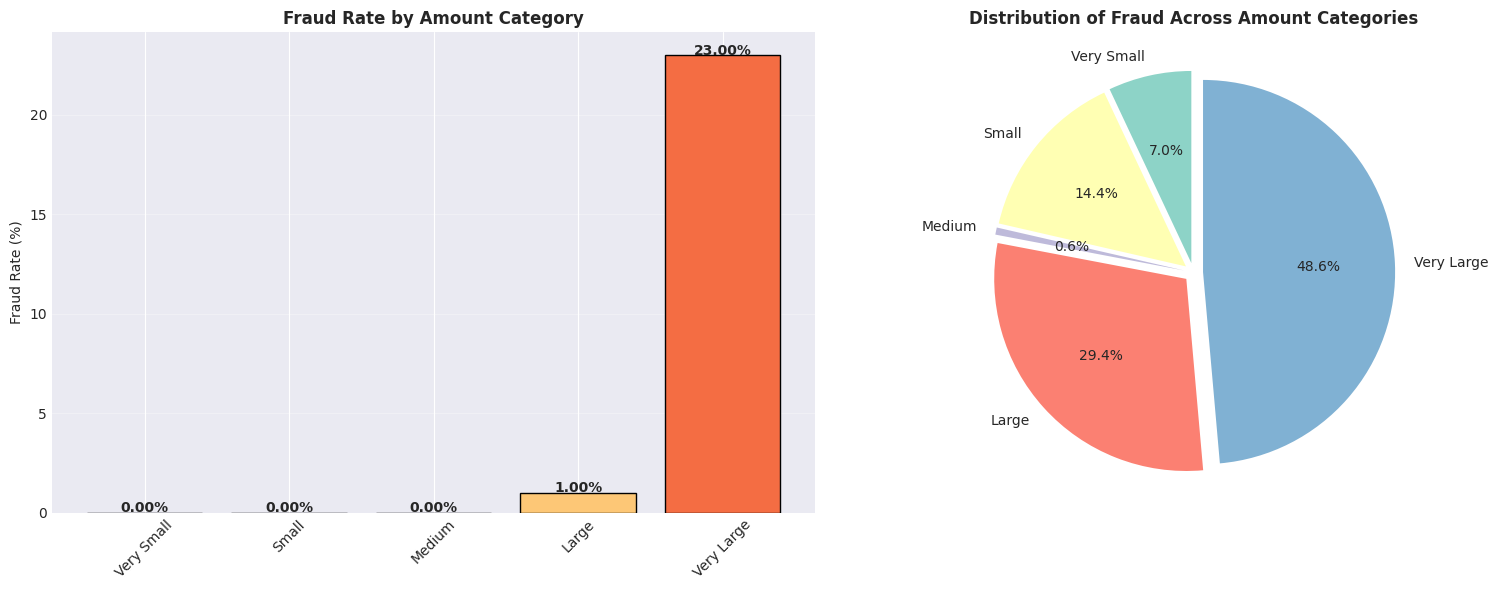


✓ Saved: reports/day3_fraud_by_amount_category.png


In [10]:
print("\n5. ANALYZING FRAUD BY AMOUNT CATEGORIES")
print("-" * 80)

amount_cat_analysis = df.groupby('amount_category').agg({
    'is_fraud': ['sum', 'mean', 'count'],
    'amt': ['mean', 'min', 'max']
}).round(2)

amount_cat_analysis.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans', 
                                'Avg_Amount', 'Min_Amount', 'Max_Amount']
amount_cat_analysis['Fraud_Rate'] = amount_cat_analysis['Fraud_Rate'] * 100

# Order by size
size_order = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
amount_cat_analysis = amount_cat_analysis.reindex(size_order)

print("\n💰 Fraud by Amount Category:")
print(amount_cat_analysis)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Fraud rate by amount category
axes[0].bar(range(len(size_order)), amount_cat_analysis['Fraud_Rate'], 
            color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(size_order))), 
            edgecolor='black')
axes[0].set_xticks(range(len(size_order)))
axes[0].set_xticklabels(size_order, rotation=45)
axes[0].set_ylabel('Fraud Rate (%)')
axes[0].set_title('Fraud Rate by Amount Category', fontweight='bold', fontsize=12)
axes[0].grid(alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(amount_cat_analysis['Fraud_Rate']):
    axes[0].text(i, v + 0.02, f'{v:.2f}%', ha='center', fontweight='bold')

# 2. Distribution of fraud across categories (pie chart)
fraud_dist = amount_cat_analysis['Fraud_Count']
colors = plt.cm.Set3(range(len(size_order)))
axes[1].pie(fraud_dist, labels=size_order, autopct='%1.1f%%', startangle=90, 
            colors=colors, explode=[0.05]*len(size_order))
axes[1].set_title('Distribution of Fraud Across Amount Categories', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/day3_fraud_by_amount_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: reports/day3_fraud_by_amount_category.png")

# 6. GEOGRAPHIC ANALYSIS


6. GEOGRAPHIC ANALYSIS OF FRAUD
--------------------------------------------------------------------------------
✓ Created: is_local_transaction (1=≤50km, 0=>50km)

📍 Top 15 States by Fraud Count:
       Fraud_Count  Fraud_Rate  Total_Trans
state                                      
NY             555        0.66        83501
TX             479        0.50        94876
PA             458        0.57        79847
CA             326        0.58        56360
OH             321        0.69        46480
FL             281        0.66        42671
IL             248        0.57        43252
MI             238        0.52        46154
AL             215        0.52        40989
MN             207        0.65        31714
VA             198        0.68        29250
SC             193        0.66        29190
MO             191        0.50        38403
NE             180        0.74        24168
WI             163        0.56        29368

🗺️ Fraud by Distance from Merchant:
             Frau

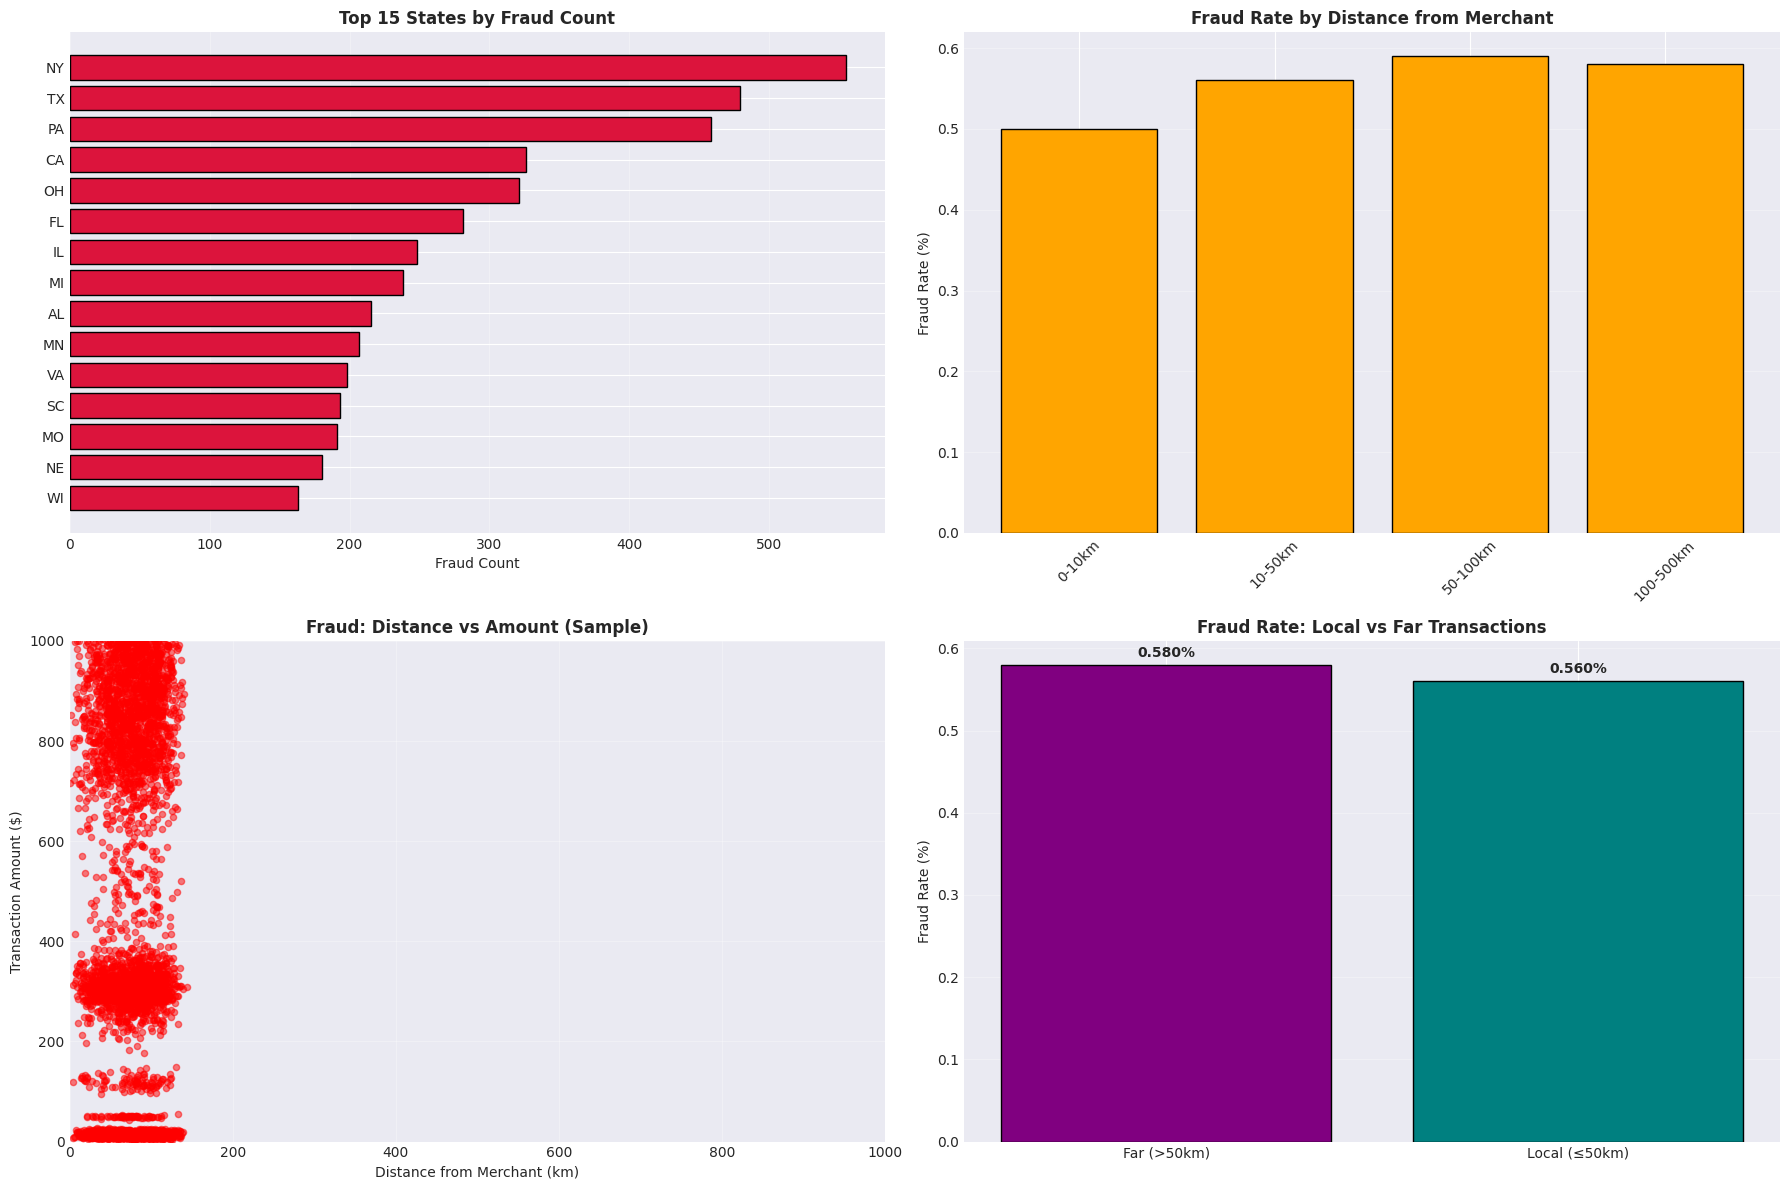


✓ Saved: reports/day3_fraud_geographic.png


In [11]:
print("\n6. GEOGRAPHIC ANALYSIS OF FRAUD")
print("-" * 80)

# Ensure df is available even if this cell is run standalone
if 'df' not in globals():
    print("⚠️ 'df' not found in memory. Loading cleaned dataset...")
    df = pd.read_csv('../data/cleaned/fraudTrain_cleaned.csv')
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
    print(f"✓ Loaded cleaned dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Normalize distance column name used in this section
if 'distance_km' not in df.columns:
    if 'distance_from_merchant_km' in df.columns:
        df['distance_km'] = df['distance_from_merchant_km']
        print("✓ Using 'distance_from_merchant_km' as 'distance_km'")
    elif {'lat', 'long', 'merch_lat', 'merch_long'}.issubset(df.columns):
        lat1 = np.radians(df['lat'].astype(float))
        lon1 = np.radians(df['long'].astype(float))
        lat2 = np.radians(df['merch_lat'].astype(float))
        lon2 = np.radians(df['merch_long'].astype(float))

        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        df['distance_km'] = 6371.0 * c
        print("✓ Computed 'distance_km' from coordinates (Haversine)")
    else:
        df['distance_km'] = np.nan
        print("⚠️ Could not create distance column; set 'distance_km' to NaN")

# Ensure local/far flag exists
if 'is_local_transaction' not in df.columns:
    df['is_local_transaction'] = np.where(df['distance_km'].notna(), (df['distance_km'] <= 50).astype(int), np.nan)
    print("✓ Created: is_local_transaction (1=≤50km, 0=>50km)")

# Top 15 states by fraud count
state_analysis = df.groupby('state').agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
state_analysis.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans']
state_analysis['Fraud_Rate'] = state_analysis['Fraud_Rate'] * 100
state_analysis = state_analysis.sort_values('Fraud_Count', ascending=False)

print("\n📍 Top 15 States by Fraud Count:")
print(state_analysis.head(15))

# Distance analysis
distance_analysis = df.groupby(pd.cut(df['distance_km'], 
                                       bins=[0, 10, 50, 100, 500, 5000], 
                                       labels=['0-10km', '10-50km', '50-100km', '100-500km', '500+km'])).agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
distance_analysis.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans']
distance_analysis['Fraud_Rate'] = distance_analysis['Fraud_Rate'] * 100

print("\n🗺️ Fraud by Distance from Merchant:")
print(distance_analysis)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 15 states by fraud count
top_states = state_analysis.head(15)
axes[0, 0].barh(range(15), top_states['Fraud_Count'], color='crimson', edgecolor='black')
axes[0, 0].set_yticks(range(15))
axes[0, 0].set_yticklabels(top_states.index)
axes[0, 0].set_xlabel('Fraud Count')
axes[0, 0].set_title('Top 15 States by Fraud Count', fontweight='bold', fontsize=12)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Fraud rate by distance
axes[0, 1].bar(range(len(distance_analysis)), distance_analysis['Fraud_Rate'], 
               color='orange', edgecolor='black')
axes[0, 1].set_xticks(range(len(distance_analysis)))
axes[0, 1].set_xticklabels(distance_analysis.index, rotation=45)
axes[0, 1].set_ylabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by Distance from Merchant', fontweight='bold', fontsize=12)
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Scatter: Distance vs Amount (fraud only)
fraud_only = df[df['is_fraud'] == 1]
if len(fraud_only) > 0:
    fraud_data = fraud_only.sample(min(5000, len(fraud_only)), random_state=42)
else:
    fraud_data = fraud_only
axes[1, 0].scatter(fraud_data['distance_km'], fraud_data['amt'], 
                   alpha=0.5, s=20, c='red')
axes[1, 0].set_xlabel('Distance from Merchant (km)')
axes[1, 0].set_ylabel('Transaction Amount ($)')
axes[1, 0].set_title('Fraud: Distance vs Amount (Sample)', fontweight='bold', fontsize=12)
axes[1, 0].set_xlim(0, 1000)
axes[1, 0].set_ylim(0, 1000)
axes[1, 0].grid(alpha=0.3)

# 4. Local vs Far transactions
local_analysis = df.groupby('is_local_transaction').agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
local_analysis.columns = ['Fraud_Count', 'Fraud_Rate', 'Total_Trans']
local_analysis['Fraud_Rate'] = local_analysis['Fraud_Rate'] * 100

axes[1, 1].bar(['Far (>50km)', 'Local (≤50km)'], local_analysis['Fraud_Rate'], 
               color=['purple', 'teal'], edgecolor='black')
axes[1, 1].set_ylabel('Fraud Rate (%)')
axes[1, 1].set_title('Fraud Rate: Local vs Far Transactions', fontweight='bold', fontsize=12)
axes[1, 1].grid(alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(local_analysis['Fraud_Rate']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/day3_fraud_geographic.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: reports/day3_fraud_geographic.png")

# 7. KEY INSIGHTS SUMMARY

In [ ]:
print("\n7. KEY INSIGHTS FROM EDA")
print("=" * 80)

insights = []

# Amount insights
fraud_amt_mean = fraud_amounts.mean()
legit_amt_mean = legit_amounts.mean()
amt_diff_pct = ((fraud_amt_mean - legit_amt_mean) / legit_amt_mean) * 100
insights.append(f"💰 Fraudulent transactions are {amt_diff_pct:.1f}% {'HIGHER' if amt_diff_pct > 0 else 'LOWER'} than legitimate (${fraud_amt_mean:.2f} vs ${legit_amt_mean:.2f})")

# Category insights
top_fraud_category = category_analysis.iloc[0]
insights.append(f"🛒 Highest fraud rate: {category_analysis.index[0]} ({top_fraud_category['Fraud_Rate']:.2f}%)")

# Time insights
peak_fraud_hour = fraud_by_hour['Fraud_Rate'].idxmax()
insights.append(f"⏰ Peak fraud hour: {peak_fraud_hour}:00 ({fraud_by_hour.loc[peak_fraud_hour, 'Fraud_Rate']:.3f}% fraud rate)")

# Weekend vs Weekday
weekend_rate = weekend_analysis.loc[1, 'Fraud_Rate']
weekday_rate = weekend_analysis.loc[0, 'Fraud_Rate']
insights.append(f"📅 {'Weekend' if weekend_rate > weekday_rate else 'Weekday'} has higher fraud rate ({max(weekend_rate, weekday_rate):.3f}%)")

# Night vs Day
night_rate = night_analysis.loc[1, 'Fraud_Rate']
day_rate = night_analysis.loc[0, 'Fraud_Rate']
insights.append(f"🌙 {'Night' if night_rate > day_rate else 'Day'} transactions have higher fraud rate ({max(night_rate, day_rate):.3f}%)")

# Distance insights
far_rate = local_analysis.loc[0, 'Fraud_Rate']
local_rate = local_analysis.loc[1, 'Fraud_Rate']
insights.append(f"🗺️ {'Far' if far_rate > local_rate else 'Local'} transactions have higher fraud rate ({max(far_rate, local_rate):.3f}%)")


print("\n🔍 KEY FINDINGS:")
for i, insight in enumerate(insights, 1):
    print(f"\n{i}. {insight}")

# Save insights to file
with open('../reports/day3_key_insights.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("DAY 3 - KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS\n")
    f.write("=" * 80 + "\n\n")
    for i, insight in enumerate(insights, 1):
        f.write(f"{i}. {insight}\n")

print("\n✓ Saved: reports/day3_key_insights.txt")



9. KEY INSIGHTS FROM EDA

🔍 KEY FINDINGS:

1. 💰 Fraudulent transactions are 685.2% HIGHER than legitimate ($531.32 vs $67.67)

2. 🛒 Highest fraud rate: shopping_net (2.00%)

3. ⏰ Peak fraud hour: 22:00 (2.880% fraud rate)

4. 📅 Weekday has higher fraud rate (0.600%)

5. 🌙 Night transactions have higher fraud rate (1.660%)

6. 🗺️ Far transactions have higher fraud rate (0.580%)

✓ Saved: reports/day3_key_insights.txt
